In [1]:
import operator
from typing import Annotated, Any, Optional

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph

from IPython.display import Image
import nest_asyncio

In [1]:
import os

openai_smart_model: str = "gpt-4o"
openai_embedding_model: str = "text-embedding-3-small"
temperature: float = 0.0
default_reflection_db_path: str = "tmp/reflection_db.json"

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="AI-Agent"
os.environ["TAVILY_API_KEY"] = "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"

# 1. Passive Goal Creator
- ユーザーの入力から具体的な目標を抽出する

## 「目標」を表現するデータモデル

In [3]:
class Goal(BaseModel):
    description: str = Field(..., description="目標の説明")

    @property 
    def text(self) -> str: # textプロパティで「目標」の値を文字列として簡単に取得できるようにする
        return f"{self.description}"

## コンポーネント実装

In [4]:
class PassiveGoalCreator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, query: str) -> Goal:
        prompt = ChatPromptTemplate.from_template(
            "ユーザーの入力を分析し、明確で実行可能な目標を生成してください。\n"
            "要件:\n"
            "1. 目標は具体的かつ明確であり、実行可能なレベルで詳細化されている必要があります。\n"
            "2. あなたが実行可能な行動は以下の行動だけです。\n"
            "   - インターネットを利用して、目標を達成するための調査を行う。\n"
            "   - ユーザーのためのレポートを生成する。\n"
            "3. 決して2.以外の行動を取ってはいけません。\n"
            "ユーザーの入力: {query}"
        )
        chain = prompt | self.llm.with_structured_output(Goal)
        return chain.invoke({"query": query})

## Main関数

In [8]:
def main():
    query = "おいしいカレーライスの作り方"
    llm = ChatOpenAI(
        model=openai_smart_model, temperature=temperature
    )
    goal_creator = PassiveGoalCreator(llm=llm)
    result: Goal = goal_creator.run(query=query)

    print(f"{result.text}")


if __name__=="__main__":
    main()
    

おいしいカレーライスを作るための具体的なレシピを調査し、ユーザーに提供する。レシピには必要な材料、調理手順、調理時間、コツやポイントを含める。


# 2. Prompt/Response Optimizer
- 生成された目標やユーザー要求を、より効率的なプロンプトに変換し、LLMから質の高い回答を得る

## 「最適化された目標」を表現するデータモデル

In [5]:
class OptimizedGoal(BaseModel):
    description: str = Field(..., description="目標の説明")
    metrics: str = Field(..., description="目標の達成度を測定する方法")

    @property
    def text(self) -> str:
        return f"{self.description}(測定基準: {self.metrics})"

## コンポーネント実装

In [6]:
class PromptOptimizer:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, query: str) -> OptimizedGoal:
        prompt = ChatPromptTemplate.from_template(
            "あなたは目標設定の専門家です。以下の目標をSMART原則（Specific: 具体的、Measurable: 測定可能、Achievable: 達成可能、Relevant: 関連性が高い、Time-bound: 期限がある）に基づいて最適化してください。\n\n"
            "# 元の目標：\n"
            "{query}\n\n"
            "# 指示:\n"
            "1. 元の目標を分析し、不足している要素や改善点を特定してください。\n"
            "2. あなたが実行可能な行動は以下の行動だけです。\n"
            "   - インターネットを利用して、目標を達成するための調査を行う。\n"
            "   - ユーザーのためのレポートを生成する。\n"
            "3. SMART原則の各要素を考慮しながら、目標を具体的かつ詳細に記載してください。\n"
            "   - 一切抽象的な表現を含んではいけません。\n"
            "   - 必ず全ての単語が実行可能かつ具体的であることを確認してください。\n"
            "4. 目標の達成度を測定する方法を具体的かつ詳細に記載してください。\n"
            "5. 元の目標で期限が指定されていない場合は、期限を考慮する必要はありません。\n"
            "6. REMEMBER: 決して2.以外の行動を取ってはいけません。"
        )
        chain = prompt | self.llm.with_structured_output(OptimizedGoal)
        return chain.invoke({"query": query})

class ResponseOptimizer:
    def __init__(self, llm:ChatOpenAI):
        self.llm = llm

    def run(self, query: str) -> str:
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    "あなたはAIエージェントシステムのレスポンス最適化スペシャリストです。与えられた目標に対して、エージェントが目標にあったレスポンスを変えるためのレスポンス仕様を策定してください。",
                ),
                (
                    "human",
                    "以下の手順に従って、レスポンス最適化プロンプトを作成してください:\n\n"
                    "1. 目標分析:\n"
                    "   - 提示された目標を分析し、主要な要素や意図を特定してください。\n\n"
                    "2. レスポンス仕様の策定:\n"
                    "   - 目標達成のための最適なレスポンス仕様を考案してください。\n"
                    "   - トーン、構造、内容の焦点などを考慮に入れてください。\n\n"
                    "3. 具体的な指示の作成:\n"
                    "   - 事前に収集された情報から、ユーザーの期待に沿ったレスポンスをするために必要な、AIエージェントに対する明確で実行可能な指示を作成してください。\n"
                    "   - あなたの指示によってAIエージェントが実行可能なのは、すでに調査済みの結果をまとめることだけです。\n"
                    "   - インターネットへのアクセスはできません。\n\n"
                    "4. 例の提供:\n"
                    "   - 可能であれば、目標に沿ったレスポンスの例を１つ以上含めてください。\n\n"
                    "5. 評価基準の設定:\n"
                    "   - レスポンスの効果を測定するための基準を定義してください。\n\n"
                    "以下の構造でレスポンス最適化プロンプトを出力してください:\n\n"
                    "目標分析:\n"
                    "[ここに目標の分析結果を記入]\n\n"
                    "レスポンス仕様:\n"
                    "[ここに策定されたレスポンス仕様を記入]\n\n"
                    "AIエージェントへの指示:\n"
                    "[ここにAIエージェントへの具体的な指示を記入]\n\n"
                    "レスポンス例:\n"
                    "[ここにレスポンス例を記入]\n\n"
                    "評価基準]\n"
                    "[ここに評価基準を記入]\n\n"
                    "では、以下の目標に対するレスポンス最適化プロンプトを作成してください:\n"
                    "{query}",
                ),
            ]
        )
        chain = prompt | self.llm | StrOutputParser()
        return chain.invoke({"query": query})


## Main関数

In [7]:
def main():
    query = "おいしいカレーライスの作り方"
    llm = ChatOpenAI(
        model=openai_smart_model, temperature=temperature
    )
    passive_goal_creator = PassiveGoalCreator(llm=llm)
    goal: Goal = passive_goal_creator.run(query=query)
    
    prompt_optimizer = PromptOptimizer(llm=llm)
    optimized_goal: OptimizedGoal = prompt_optimizer.run(query=goal.text)

    response_optimizer = ResponseOptimizer(llm=llm)
    optimized_response: str = response_optimizer.run(query=optimized_goal.text)

    print("##### Response by Passive Goal Creator #####")
    print(f"{goal.text}")
    print("\n\n\n")

    print("##### Response by Prompt Optimizer #####")
    print(f"{optimized_goal.text}")
    print("\n\n\n")

    print("##### Response by Response Optimizer #####")
    print(f"{optimized_response}")


if __name__=="__main__":
    main()

##### Response by Passive Goal Creator #####
おいしいカレーライスを作るための具体的なレシピを調査し、ユーザーに提供する。レシピには必要な材料、調理手順、調理時間、そしておいしく作るためのコツを含める。




##### Response by Prompt Optimizer #####
インターネットを利用して、2023年12月31日までにおいしいカレーライスを作るための具体的なレシピを調査し、ユーザーに提供する。レシピには、必要な材料、調理手順、調理時間、そしておいしく作るためのコツを含める。調査結果を基に、ユーザーのための詳細なレポートを生成する。(測定基準: 提供したレシピの詳細度（材料のリスト、調理手順、調理時間、コツの有無）を評価し、ユーザーからのフィードバックを収集して満足度を測定する。具体的には、ユーザーがレシピを使用して実際にカレーライスを作り、その結果を5段階評価でフィードバックする。フィードバックの平均スコアが4以上であれば目標達成とする。)




##### Response by Response Optimizer #####
目標分析:
この目標は、ユーザーが2023年12月31日までにおいしいカレーライスを作るための具体的なレシピを提供することに焦点を当てています。主要な要素は、必要な材料、調理手順、調理時間、そしておいしく作るためのコツを含む詳細なレシピの提供です。ユーザーの満足度を測定するために、フィードバックを収集し、5段階評価での平均スコアを基準としています。

レスポンス仕様:
- トーン: 親しみやすく、分かりやすいトーンで、初心者でも理解しやすいようにする。
- 構造: 材料リスト、調理手順、調理時間、コツの順に明確に分けて記載する。
- 内容の焦点: 材料の具体的な量、手順の詳細、調理時間の目安、そしておいしく作るためのコツを強調する。

AIエージェントへの指示:
1. 事前に収集されたカレーライスのレシピ情報を基に、以下の要素を含む詳細なレシピを作成してください。
   - 必要な材料とその具体的な量
   - 調理手順をステップごとに詳細に記載
   - 調理時間の目安を提供
   - おいしく作るためのコツを含める
2. レシピは初心者でも理解しやすいように、簡

# 3. Single-Path Plan Generator
- 設定された目標を達成するための一連の具体的なステップを生成

In [17]:
import operator
from datetime import datetime
from typing import Annotated, Any

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field

from IPython.display import Image
import nest_asyncio

from Agents.passive_goal_creator import Goal, PassiveGoalCreator
from Agents.prompt_optimizer import OptimizedGoal, PromptOptimizer
from Agents.response_optimizer import ResponseOptimizer

## タスク分解とSingle-Path plan generatorのデータモデル

In [13]:
class DecomposedTasks(BaseModel):
    values: list[str] = Field(
        default_factory=list,
        min_items=3,
        max_items=5,
        description="3~5個に分解されたタスク",
    )

class SinglePathPlanGenerationState(BaseModel):
    query: str = Field(..., description="ユーザーが入力したクエリ")
    optimized_goal: str = Field(
        default="", 
        description="最適化された目標"
    )
    optimized_response: str = Field(
        default="",
        description="最適化されたレスポンス定義"
    )
    tasks: list[str] = Field(
        default_factory=list,
        description="実行するタスクのリスト"
    )
    current_task_index: int = Field(
        default=0,
        description="現在実行中のタスク番号"
    )
    results: Annotated[list[str], operator.add] = Field(
        default_factory=list,
        description="実行済みタスクの結果リスト"
    )
    final_output: str = Field(
        default="",
        description="最終的な出力結果"
    )

## コンポーネント実装

In [10]:
class QueryDecomposer:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.current_date = datetime.now().strftime("%Y-%m-%d")

    def run(self, query: str) -> DecomposedTasks:
        prompt = ChatPromptTemplate.from_template(
            f"CURRENT DATE: {self.current_date}\n"
            "-----\n"
            "タスク: 与えられた目標を具体的で実行可能なタスクに分解してください。\n"
            "要件:\n"
            "1. 以下の行動だけで目標を達成すること。決して指定された以外の行動をとらないこと。\n"
            "   - インターネットを利用して、目標を達成するための調査を行う。\n"
            "2. 各タスクは具体的かつ詳細に記載されており、単独で実行ならびに検証可能な情報を含めること。一切抽象的な表現を含まないこと。\n"
            "3. タスクは実行可能な順序でリスト化すること。\n"
            "4. タスクは日本語で出力すること。\n"
            "目標: {query}"
        )
        chain = prompt | self.llm.with_structured_output(DecomposedTasks)
        return chain.invoke({"query": query})

In [11]:
class TaskExecutor:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.tools = [TavilySearchResults(max_results=3)]

    def run(self, task: str) -> str:
        agent = create_react_agent(self.llm, self.tools) # 引数で指定したツールを利用してタスクを実行するAIエージェントを作成
        result = agent.invoke(
            {
                "messages": [
                    (
                        "human",
                        (
                            "次のタスクを実行し、詳細な回答を提供してください。\n\n"
                            f"タスク: {task}\n\n"
                            "要件: \n"
                            "1. 必要に応じて提供されたツールを使用してください。\n"
                            "2. 実行は徹底的かつ包括的に行ってください。\n"
                            "3. 可能な限り具体的な事実やデータを提供してください。\n"
                            "4. 発見した内容を明確に要約してください。\n"
                        ),
                    )
                ]
            }
        )
        return result["messages"][-1].content

In [12]:
class ResultAggregator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, query: str, response_definition: str, results: list[str]) -> str:
        prompt = ChatPromptTemplate.from_template(
            "与えられた目標:\n{query}\n\n"
            "調査結果:\n{results}\n\n"
            "与えられた目標に対し、調査結果を用いて、以下の指示に基づいてレスポンスを生成してください。\n"
            "{response_definition}"
        )
        result_str = "\n\n".join(
            f"Info {i+1}:\n{result}" for i, result in enumerate(results)
        )
        chain = prompt | self.llm | StrOutputParser()
        return chain.invoke(
            {
                "query": query,
                "results": result_str,
                "response_definition": response_definition,
            }
        )

In [16]:
class SinglePathPlanGeneration:
    def __init__(self, llm: ChatOpenAI):
        self.passive_goal_creator = PassiveGoalCreator(llm=llm)
        self.prompt_optimizer = PromptOptimizer(llm=llm)
        self.response_optimizer = ResponseOptimizer(llm=llm)
        self.query_decomposer = QueryDecomposer(llm=llm)
        self.task_executor = TaskExecutor(llm=llm)
        self.result_aggregator = ResultAggregator(llm=llm)
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        graph = StateGraph(SinglePathPlanGenerationState)
        graph.add_node("goal_setting", self._goal_setting)
        graph.add_node("decompose_query", self._decompose_query)
        graph.add_node("execute_task", self._execute_task)
        graph.add_node("aggregate_results", self._aggregate_results)
        graph.set_entry_point("goal_setting")
        graph.add_edge("goal_setting", "decompose_query")
        graph.add_edge("decompose_query", "execute_task")
        graph.add_conditional_edges(
            "execute_task",
            lambda state: state.current_task_index < len(state.tasks),
            {True: "execute_task", False: "aggregate_results"},
        )
        graph.add_edge("aggregate_results", END)
        return graph.compile()

    def _goal_setting(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
        # プロンプト最適化
        goal: Goal = self.passive_goal_creator.run(query=state.query)
        optimized_goal: OptimizedGoal = self.prompt_optimizer.run(query=goal.text)
        # レスポンス最適化
        optimized_response: str = self.response_optimizer.run(query=optimized_goal.text)
        return {
            "optimized_goal": optimized_goal.text,
            "optimized_response": optimized_response,
        }

    def _decompose_query(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
        # 最適化された目標からタスクの分解
        decomposed_tasks: DecomposedTasks = self.query_decomposer.run(query=state.optimized_goal)
        return {"tasks": decomposed_tasks.values}

    def _execute_task(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
        # タスクを実行
        current_task = state.tasks[state.current_task_index]
        result = self.task_executor.run(task=current_task)
        return {
            "results": [result],
            "current_task_index": state.current_task_index + 1,
        }

    def _aggregate_results(self, state: SinglePathPlanGenerationState) -> dict[str, Any]:
        final_output = self.result_aggregator.run(
            query=state.optimized_goal,
            response_definition=state.optimized_response,
            results=state.results,
        )
        return {"final_output": final_output}

    def graph_visualization(self):
        nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    def run(self, query: str) -> str:
        initial_state = SinglePathPlanGenerationState(query=query)
        final_state = self.graph.invoke(initial_state, {"recursion_limit": 1000})
        return final_state.get("final_output", "Failed to generate a final response.")


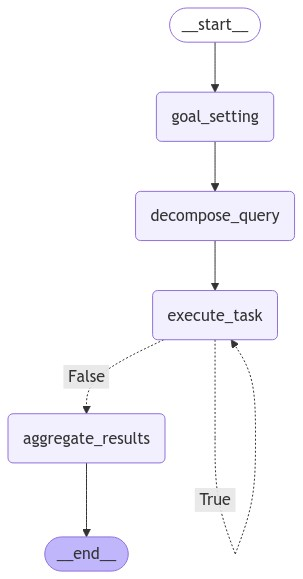

In [18]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
agent = SinglePathPlanGeneration(llm=llm)
agent.graph_visualization()

In [15]:
def main():
    query = "おいしいカレーライスの作り方"
    llm = ChatOpenAI(
        model=openai_smart_model, temperature=temperature
    )
    agent = SinglePathPlanGeneration(llm=llm)
    result = agent.run(query)
    
    print(result)

if __name__=="__main__":
    main()

以下に、3つの異なるカレーライスのレシピをまとめました。それぞれのレシピには、材料リスト、調理手順、調理時間、調理のコツやポイントが含まれています。これらの情報を基に、カレーライス作りをお楽しみください。

---

### レシピ1: 驚愕のカレーライス

- **材料リスト**:
  - 牛肉: 300g
  - にんにく: 1片
  - しょうが: 1片
  - 玉ねぎ: 2個
  - にんじん: 1本
  - じゃがいも: 2個
  - カレールウ: 2種類（各1/2箱）
  - サラダ油: 大さじ2
  - 塩: 少々
  - 胡椒: 少々
  - 水: 600ml

- **調理手順**:
  1. 牛肉に塩と胡椒を振り、サラダ油を熱した鍋でしっかり焼き色をつける。
  2. にんにくとしょうがをみじん切りにし、鍋に加えて炒める。
  3. 玉ねぎ、にんじん、じゃがいもを一口大に切り、鍋に加えて炒める。
  4. 水を加え、蓋をして野菜が柔らかくなるまで煮る。
  5. カレールウを溶かし、さらに10分煮込む。

- **調理時間**: 約40分

- **調理のコツやポイント**: 
  - 牛肉にしっかりと焼き色をつけることで、旨味が引き立ちます。
  - ルウを2種類使うことで、より深い味わいが楽しめます。

---

### レシピ2: 栗原はるみのカレーライス

- **材料リスト**:
  - 鶏もも肉: 300g
  - バジル: 適量
  - カレーソース: 200ml
  - 白ワイン: 50ml
  - ご飯: 適量
  - 福神漬け: 適量
  - 酢じょうゆ卵: 2個

- **調理手順**:
  1. 鶏もも肉を一口大に切り、フライパンで炒める。
  2. カレーソースと白ワインを加え、煮込む。
  3. バジルを加えて香りを引き立てる。
  4. ご飯と一緒に盛り付け、福神漬けと酢じょうゆ卵を添える。

- **調理時間**: 約30分

- **調理のコツやポイント**:
  - 玉ねぎを丁寧に炒めることで、スパイスの香りが引き立ちます。
  - バジルを加えることで、爽やかな香りがプラスされます。

---

### レシピ3: クックパッドの定番カレーライス

- **材料リスト**:
  - 牛肉または鶏肉: 300g

# 4. Multi-Path Plan Generator
- タスク分解時に複数の選択肢を同時に生成
- 実行時のコンテキストに応じて実行エージェントに都度適切な選択をさせる

In [11]:
import operator
from datetime import datetime
from typing import Annotated, Any

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import ConfigurableField
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field

from IPython.display import Image
import nest_asyncio

from Agents.passive_goal_creator import Goal, PassiveGoalCreator
from Agents.prompt_optimizer import OptimizedGoal, PromptOptimizer
from Agents.response_optimizer import ResponseOptimizer

## データモデル

In [12]:
class TaskOption(BaseModel):
    description: str = Field(default="", description="タスクオプションの説明")

class Task(BaseModel):
    task_name: str = Field(..., description="タスクの名前")
    options: list[TaskOption] = Field(
        default_factory=list,
        min_items=2,
        max_items=3,
        description="2~3個のタスクオプション",
    )

class DecomposedTasks(BaseModel):
    values: list[Task] = Field(
        default_factory=list,
        min_items=3,
        max_items=5,
        description="3~5個に分解されたタスク",
    )

class MultiPathPlanGenerationState(BaseModel):
    query: str = Field(..., description="ユーザーが入力したクエリ")
    optimized_goal: str = Field(
        default="", 
        description="最適化された目標"
    )
    optimized_response: str = Field(
        default="",
        description="最適化されたレスポンス定義"
    )
    tasks: DecomposedTasks = Field(
        default_factory=DecomposedTasks,
        description="複数のオプションを持つタスクのリスト"
    )
    current_task_index: int = Field(
        default=0,
        description="現在実行中のタスク番号"
    )
    chosen_options: Annotated[list[int], operator.add] = Field(
        default_factory=list,
        description="各タスクで選択されたオプションのインデックス"
    )
    results: Annotated[list[str], operator.add] = Field(
        default_factory=list,
        description="実行済みタスクの結果リスト"
    )
    final_output: str = Field(
        default="",
        description="最終的な出力結果"
    )

## コンポーネント実装

In [13]:
class QueryDecomposer:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.current_date = datetime.now().strftime("%Y-%m-%d")

    def run(self, query: str) -> DecomposedTasks:
        prompt = ChatPromptTemplate.from_template(
            f"CURRENT DATE: {self.current_date}\n"
            "-----\n"
            "タスク: 与えられた目標を3~5個の高レベルタスクに分解し、各タスクに2~3個の具体的なオプションを提供してください。\n"
            "要件:\n"
            "1. 以下の行動だけで目標を達成すること。決して指定された以外の行動をとらないこと。\n"
            "   - インターネットを利用して、目標を達成するための調査を行う。\n"
            "2. 各高レベルタスクは具体的かつ詳細に記載されており、単独で実行ならびに検証可能な情報を含めること。一切抽象的な表現を含まないこと。\n"
            "3. 各高レベルタスクに2~3個の異なるアプローチまたはオプションを提供すること。\n"
            "4. タスクは実行可能な順序でリスト化すること。\n"
            "5. タスクは日本語で出力すること。\n\n"
            "REMEMBER: 実行できないタスク、ならびに選択肢は絶対に作成しないでください。\n\n"
            "目標: {query}"
        )
        chain = prompt | self.llm.with_structured_output(DecomposedTasks)
        return chain.invoke({"query": query})

In [14]:
class OptionPresenter:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm.configurable_fields(
            max_tokens=ConfigurableField(id="max_tokens")
        )

    def run(self, task: Task) -> int:
        task_name = task.task_name
        options = task.options

        print(f"\nタスク: {task_name}")
        for i, option in enumerate(options):
            print(f"{i + 1}. {option.description}")

        choice_prompt = ChatPromptTemplate.from_template(
            "タスク: 与えられたタスクとオプションに基づいて、最適なオプションを選択してください。必ず番号のみで回答してください。\n\n"
            "なお、あなたは次の行動しかできません。\n"
            "- インターネットを利用して、目標を達成するための調査を行う。\n\n"
            "タスク: {task_name}\n"
            "オプション:\n{options_text}\n"
            "選択 (1-{num_options}): "
        )

        options_text = "\n".join(
            f"{i+1}. {option.description}" for i, option in enumerate(options)
        )
        chain = (
            choice_prompt
            | self.llm.with_config(configurable=dict(max_tokens=1))
            | StrOutputParser()
        )
        choice_str = chain.invoke(
            {
                "task_name": task_name,
                "options_text": options_text,
                "num_options": len(options),
            }
        )
        print(f"==> エージェントの選択: {choice_str}\n")

        return int(choice_str.strip()) - 1 # .strip() : 前後の空白を削除

In [15]:
class TaskExecutor:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.tools = [TavilySearchResults(max_results=3)]

    def run(self, task: Task, chosen_option: TaskOption) -> str:
        agent = create_react_agent(self.llm, self.tools)
        result = agent.invoke(
            {
                "messages": [
                    (
                        "human",
                        f"以下のタスクを実行し、詳細な回答を提供してください:\n\n"
                        f"タスク: {task.task_name}\n"
                        f"選択されたアプローチ: {chosen_option.description}\n\n"
                        f"要件:\n"
                        f"1. 必要に応じて提供されたツールを使用すること。\n"
                        f"2. 実行において徹底的かつ包括的であること。\n"
                        f"3. 可能な限り具体的な事実やデータを提供すること。\n"
                        f"4. 発見事項を明確にまとめること。\n",
                    )
                ]
            }
        )
        return result["messages"][-1].content

In [16]:
class ResultAggregator:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm

    def run(self, query: str, response_definition: str, tasks: list[Task], chosen_options: list[int], results: list[str]) -> str:
        prompt = ChatPromptTemplate.from_template(
            "与えられた目標:\n{query}\n\n"
            "調査結果:\n{task_results}\n\n"
            "与えられた目標に対し、調査結果を用いて、以下の指示に基づいてレスポンスを生成してください。\n"
            "{response_definition}"
        )
        task_results = self._format_task_results(tasks, chosen_options, results)
        chain = prompt | self.llm | StrOutputParser()
        return chain.invoke(
            {
                "query": query,
                "task_results": task_results,
                "response_definition": response_definition,
            }
        )

    @staticmethod # class内で独立した関数として使う（つまり、class内の他の変数にアクセスできないメソッド）
    def _format_task_results(tasks: list[Task], chosen_options: list[int], results: list[str]) -> str:
        task_results = ""
        for i, (task, chosen_option, result) in enumerate(zip(tasks, chosen_options, results)):
            task_name = task.task_name
            chosen_option_desc = task.options[chosen_option].description
            task_results += f"タスク {i+1}: {task_name}\n"
            task_results += f"選択されたアプローチ: {chosen_option_desc}\n"
            task_results += f"結果: {result}\n\n"
        return task_results


In [17]:
class MultiPathPlanGeneration:
    def __init__(self, llm: ChatOpenAI):
        self.llm = llm
        self.passive_goal_creator = PassiveGoalCreator(llm=self.llm)
        self.prompt_optimizer = PromptOptimizer(llm=self.llm)
        self.response_optimizer = ResponseOptimizer(llm=self.llm)
        self.query_decomposer = QueryDecomposer(llm=self.llm)
        self.option_presenter = OptionPresenter(llm=self.llm)
        self.task_executor = TaskExecutor(llm=self.llm)
        self.result_aggregator = ResultAggregator(llm=self.llm)
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        graph = StateGraph(MultiPathPlanGenerationState)
        graph.add_node("goal_setting", self._goal_setting)
        graph.add_node("decompose_query", self._decompose_query)
        graph.add_node("present_options", self._present_options)
        graph.add_node("execute_task", self._execute_task)
        graph.add_node("aggregate_results", self._aggregate_results)
        graph.set_entry_point("goal_setting")
        graph.add_edge("goal_setting", "decompose_query")
        graph.add_edge("decompose_query", "present_options")
        graph.add_edge("present_options", "execute_task")
        graph.add_conditional_edges(
            "execute_task",
            lambda state: state.current_task_index < len(state.tasks.values),
            {True: "present_options", False: "aggregate_results"},
        )
        graph.add_edge("aggregate_results", END)

        return graph.compile()

    def _goal_setting(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        # プロンプト最適化
        goal: Goal = self.passive_goal_creator.run(query=state.query)
        optimized_goal: OptimizedGoal = self.prompt_optimizer.run(query=goal.text)
        # レスポンス最適化
        optimized_response: str = self.response_optimizer.run(query=optimized_goal.text)
        return {
            "optimized_goal": optimized_goal.text,
            "optimized_response": optimized_response,
        }

    def _decompose_query(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        # 最適化された目標からタスクの分解
        tasks = self.query_decomposer.run(query=state.optimized_goal)
        return {"tasks": tasks}

    def _present_options(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        current_task = state.tasks.values[state.current_task_index]
        chosen_option = self.option_presenter.run(task=current_task)
        return {"chosen_options": [chosen_option]}

    def _execute_task(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        # タスクを実行
        current_task = state.tasks.values[state.current_task_index]
        chosen_option = current_task.options[state.chosen_options[-1]]
        result = self.task_executor.run(
            task=current_task,
            chosen_option=chosen_option,
        )
        return {
            "results": [result],
            "current_task_index": state.current_task_index + 1,
        }

    def _aggregate_results(self, state: MultiPathPlanGenerationState) -> dict[str, Any]:
        final_output = self.result_aggregator.run(
            query=state.optimized_goal,
            response_definition=state.optimized_response,
            tasks=state.tasks.values,
            chosen_options=state.chosen_options,
            results=state.results,
        )
        return {"final_output": final_output}

    def graph_visualization(self):
        nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    def run(self, query: str) -> str:
        initial_state = MultiPathPlanGenerationState(query=query)
        final_state = self.graph.invoke(initial_state, {"recursion_limit": 1000})
        return final_state.get("final_output", "最終的な回答の生成に失敗しました。")

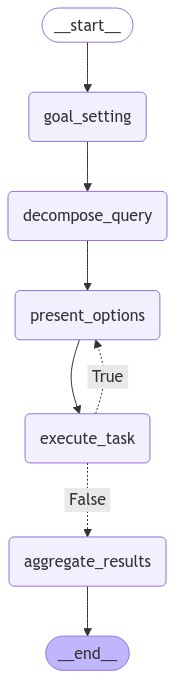

In [18]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
agent = MultiPathPlanGeneration(llm=llm)
agent.graph_visualization()

In [19]:
def main():
    query = "おいしいカレーライスの作り方"
    llm = ChatOpenAI(
        model=openai_smart_model, temperature=temperature
    )
    agent = MultiPathPlanGeneration(llm=llm)
    result = agent.run(query)

    print("\n=== 最終出力 ===")
    print(result)

if __name__=="__main__":
    main()


タスク: 5つの異なるレシピサイトを選定する
1. Google検索を使用して、人気のあるレシピサイトを探す。例えば、クックパッド、楽天レシピ、オールレシピなど。
2. SNSや料理ブログでおすすめされているレシピサイトを調査する。
3. 料理に特化したフォーラムやコミュニティで、信頼できるレシピサイトの情報を収集する。
==> エージェントの選択: 1


タスク: 各サイトからカレーライスのレシピを1つずつ選ぶ
1. 各サイトの検索機能を使って、カレーライスのレシピを探し、レビューや評価が高いものを選ぶ。
2. 各サイトの人気レシピランキングを確認し、上位にランクインしているカレーライスのレシピを選ぶ。
3. 各サイトで「カレーライス」で検索し、写真が美味しそうなレシピを選ぶ。
==> エージェントの選択: 2


タスク: 各レシピの特徴、材料、手順を詳細に記録する
1. レシピページを印刷またはPDFとして保存し、特徴、材料、手順を手書きでメモする。
2. レシピの特徴、材料、手順をテキストエディタにコピーし、整理する。
3. スクリーンショットを撮り、画像編集ソフトで特徴、材料、手順を注釈として追加する。
==> エージェントの選択: 2


タスク: 各レシピの写真を収集する
1. レシピページから直接写真をダウンロードする。
2. スクリーンショットを撮って、写真を保存する。
3. レシピサイトの許可を得て、写真を使用する。
==> エージェントの選択: 3


タスク: レポートを作成し、比較分析を行う
1. ワードプロセッサを使用して、各レシピの特徴、材料、手順を比較し、A4サイズで3ページ以上のレポートを作成する。
2. プレゼンテーションソフトを使って、スライド形式でレポートを作成し、印刷してA4サイズで3ページ以上にする。
3. オンラインのレポート作成ツールを利用して、各レシピの情報を整理し、A4サイズで3ページ以上のレポートを作成する。
==> エージェントの選択: 1


=== 最終出力 ===
以下は、5つの異なるレシピサイトから収集したカレーライスのレシピを比較したレポートの概要です。各レシピの特徴、材料、手順を詳細に記載し、最後に比較分析を行います。写真の説明も含めて、A4サイズで3ページ以上になるように情報を整理しました。


# 5. Self Reflection
- タスクの実行結果をエージェント自身で振り返ることにより、その実行内容を改善させる

In [2]:
import operator
from datetime import datetime
from typing import Annotated, Any

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import ConfigurableField
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field

from IPython.display import Image
import nest_asyncio

from Agents.passive_goal_creator import Goal, PassiveGoalCreator
from Agents.prompt_optimizer import OptimizedGoal, PromptOptimizer
from Agents.response_optimizer import ResponseOptimizer
from Agents.reflection_manager import Reflection, ReflectionManager, TaskReflector

## データモデル

In [3]:
def format_reflections(reflections: list[Reflection]) -> str:
    return (
        "\n\n".join(
            f"<ref_{i}><task>{r.task}</task><reflection>{r.reflection}</reflection></ref_{i}>"
            for i, r in enumerate(reflections)
        )
        if reflections
        else "No relevant past reflections."
    )

class DecomposedTasks(BaseModel):
    values: list[str] = Field(
        default_factory=list,
        min_items=3,
        max_items=5,
        description="3~5個に分解されたタスク",
    )

class ReflectiveAgentState(BaseModel):
    query: str = Field(..., description="ユーザーが最初に入力したクエリ")
    optimized_goal: str = Field(
        default="", 
        description="最適化された目標"
    )
    optimized_response: str = Field(
        default="",
        description="最適化されたレスポンス定義"
    )
    tasks: list[str] = Field(
        default_factory=list,
        description="実行するタスクのリスト"
    )
    current_task_index: int = Field(
        default=0,
        description="現在実行中のタスク番号"
    )
    results: Annotated[list[str], operator.add] = Field(
        default_factory=list,
        description="実行済みタスクの結果リスト"
    )
    reflection_ids: Annotated[list[str], operator.add] = Field(
        default_factory=list,
        description="リフレクション結果のIDリスト"
    )
    final_output: str = Field(
        default="",
        description="最終的な出力結果"
    )
    retry_count: int = Field(
        default=0,
        description="タスクの再試行回数"
    )


## コンポーネント実装

In [4]:
class ReflectiveGoalCreator:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm
        self.reflection_manager = reflection_manager
        self.passive_goal_creator = PassiveGoalCreator(llm=self.llm)
        self.prompt_optimizer = PromptOptimizer(llm=self.llm)

    def run(self, query: str) -> str:
        relevant_reflections = self.reflection_manager.get_relevant_reflections(query)
        reflection_text = format_reflections(relevant_reflections)

        query = f"{query}\n\n目標設定する際に以下の過去のふりかえりを考慮すること:\n{reflection_text}"
        goal: Goal = self.passive_goal_creator.run(query=query)
        optimized_goal: OptimizedGoal = self.prompt_optimizer.run(query=goal.text)
        return optimized_goal.text

In [5]:
class ReflectiveResponseOptimizer:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm
        self.reflection_manager = reflection_manager
        self.response_optimizer = ResponseOptimizer(llm=llm)

    def run(self, query: str) -> str:
        relevant_reflections = self.reflection_manager.get_relevant_reflections(query)
        reflection_text = format_reflections(relevant_reflections)

        query = f"{query}\n\nレスポンス最適化に以下の過去のふりかえりを考慮すること:\n{reflection_text}"
        optimized_response: str = self.response_optimizer.run(query=query)
        return optimized_response

In [6]:
class QueryDecomposer:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm.with_structured_output(DecomposedTasks)
        self.current_date = datetime.now().strftime("%Y-%m-%d")
        self.reflection_manager = reflection_manager

    def run(self, query: str) -> DecomposedTasks:
        relevant_reflections = self.reflection_manager.get_relevant_reflections(query)
        reflection_text = format_reflections(relevant_reflections)
        prompt = ChatPromptTemplate.from_template(
            f"CURRENT_DATE: {self.current_date}\n"
            "-----\n"
            "タスク: 与えられた目標を具体的で実行可能なタスクに分解してください。\n"
            "要件:\n"
            "1. 以下の行動だけで目標を達成すること。決して指定された以外の行動をとらないこと。\n"
            "   - インターネットを利用して、目標を達成するための調査を行う。\n"
            "2. 各タスクは具体的かつ詳細に記載されており、単独で実行ならびに検証可能な情報を含めること。一切抽象的な表現を含まないこと。\n"
            "3. タスクは実行可能な順序でリスト化すること。\n"
            "4. タスクは日本語で出力すること。\n"
            "5. タスクを作成する際に以下の過去のふりかえりを考慮すること:\n{reflections}\n\n"
            "目標: {query}"
        )
        chain = prompt | self.llm
        tasks = chain.invoke({"query": query, "reflections": reflection_text})
        return tasks

In [7]:
class TaskExecutor:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm
        self.reflection_manager = reflection_manager
        self.current_date = datetime.now().strftime("%Y-%m-%d")
        self.tools = [TavilySearchResults(max_results=3)]

    def run(self, task: str) -> str:
        relevant_reflections = self.reflection_manager.get_relevant_reflections(task)
        reflection_text = format_reflections(relevant_reflections)
        agent = create_react_agent(self.llm, self.tools)
        result = agent.invoke(
            {
                "messages": [
                    (
                        "human",
                        f"CURRENT_DATE: {self.current_date}\n"
                        "-----\n"
                        f"次のタスクを実行し、詳細な回答を提供してください。\n\nタスク: {task}\n\n"
                        "要件:\n"
                        "1. 必要に応じて提供されたツールを使用すること。\n"
                        "2. 実行において徹底的かつ包括的であること。\n"
                        "3. 可能な限り具体的な事実やデータを提供すること。\n"
                        "4. 発見事項を明確に要約すること。\n"
                        f"5. 以下の過去のふりかえりを考慮すること:\n{reflection_text}\n",
                    )
                ]
            }
        )
        return result["messages"][-1].content

In [8]:
class ResultAggregator:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager):
        self.llm = llm
        self.reflection_manager = reflection_manager
        self.current_date = datetime.now().strftime("%Y-%m-%d")

    def run(self, query: str, results: list[str], reflection_ids: list[str], response_definition: str) -> str:
        relevant_reflections = [
            self.reflection_manager.get_reflection(rid) for rid in reflection_ids
        ]
        prompt = ChatPromptTemplate.from_template(
            "与えられた目標:\n{query}\n\n"
            "調査結果:\n{results}\n\n"
            "与えられた目標に対し、調査結果を用いて、以下の指示に基づいてレスポンスを生成してください。\n"
            "{response_definition}\n\n"
            "過去の振り返りを考慮すること:\n{reflection_text}\n"
        )
        result_str = "\n\n".join(
            f"Info {i+1}:\n{result}" for i, result in enumerate(results)
        )
        chain = prompt | self.llm | StrOutputParser()
        return chain.invoke(
            {
                "query": query,
                "results": result_str,
                "response_definition": response_definition,
                "reflection_text": format_reflections(relevant_reflections),
            }
        )

In [9]:
class ReflectiveAgent:
    def __init__(self, llm: ChatOpenAI, reflection_manager: ReflectionManager, task_reflector: TaskReflector, max_retries: int = 2):
        self.reflection_manager = reflection_manager
        self.task_reflector = task_reflector
        self.reflective_goal_creator = ReflectiveGoalCreator(llm=llm, reflection_manager=self.reflection_manager)
        self.reflective_response_optimizer = ReflectiveResponseOptimizer(llm=llm, reflection_manager=self.reflection_manager)
        self.query_decomposer = QueryDecomposer(llm=llm, reflection_manager=self.reflection_manager)
        self.task_executor = TaskExecutor(llm=llm, reflection_manager=self.reflection_manager)
        self.result_aggregator = ResultAggregator(llm=llm, reflection_manager=self.reflection_manager)
        self.max_retries = max_retries
        self.graph = self._create_graph()

    def _create_graph(self) -> StateGraph:
        graph = StateGraph(ReflectiveAgentState)
        graph.add_node("goal_setting", self._goal_setting)
        graph.add_node("decompose_query", self._decompose_query)
        graph.add_node("execute_task", self._execute_task)
        graph.add_node("reflect_on_task", self._reflect_on_task)
        graph.add_node("update_task_index", self._update_task_index)
        graph.add_node("aggregate_results", self._aggregate_results)
        graph.set_entry_point("goal_setting")
        graph.add_edge("goal_setting", "decompose_query")
        graph.add_edge("decompose_query", "execute_task")
        graph.add_edge("execute_task", "reflect_on_task")
        graph.add_conditional_edges(
            "reflect_on_task",
            self._should_retry_or_continue,
            {
                "retry": "execute_task",
                "continue": "update_task_index",
                "finish": "aggregate_results",
            },
        )
        graph.add_edge("update_task_index", "execute_task")
        graph.add_edge("aggregate_results", END)
        return graph.compile()

    def _goal_setting(self, state: ReflectiveAgentState) -> dict[str, Any]:
        # プロンプト最適化
        optimized_goal: str = self.reflective_goal_creator.run(query=state.query)
        # レスポンス最適化
        optimized_response: str = self.reflective_response_optimizer.run(query=optimized_goal)
        return {
            "optimized_goal": optimized_goal,
            "optimized_response": optimized_response,
        }

    def _decompose_query(self, state: ReflectiveAgentState) -> dict[str, Any]:
        # 最適化された目標からタスクの分解
        tasks: DecomposedTasks = self.query_decomposer.run(query=state.optimized_goal)
        return {"tasks": tasks.values}

    def _execute_task(self, state: ReflectiveAgentState) -> dict[str, Any]:
        # タスクを実行
        current_task = state.tasks[state.current_task_index]
        result = self.task_executor.run(task=current_task)
        return {"results": [result], "current_task_index": state.current_task_index}

    def _reflect_on_task(self, state: ReflectiveAgentState) -> dict[str, Any]:
        current_task = state.tasks[state.current_task_index]
        current_result = state.results[-1]
        reflection = self.task_reflector.run(task=current_task, result=current_result)
        return {
            "reflection_ids": [reflection.id],
            "retry_count": (
                state.retry_count + 1 if reflection.judgment.needs_retry else 0
            ),
        }

    def _should_retry_or_continue(self, state: ReflectiveAgentState) -> str:
        latest_reflection_id = state.reflection_ids[-1]
        latest_reflection = self.reflection_manager.get_reflection(latest_reflection_id)
        if (
            latest_reflection
            and latest_reflection.judgment.needs_retry
            and state.retry_count < self.max_retries
        ):
            return "retry"
        elif state.current_task_index < len(state.tasks) - 1:
            return "continue"
        else:
            return "finish"

    def _update_task_index(self, state: ReflectiveAgentState) -> dict[str, Any]:
        return {"current_task_index": state.current_task_index + 1}

    def _aggregate_results(self, state: ReflectiveAgentState) -> dict[str, Any]:
        final_output = self.result_aggregator.run(
            query=state.optimized_goal,
            results=state.results,
            reflection_ids=state.reflection_ids,
            response_definition=state.optimized_response,
        )
        return {"final_output": final_output}

    def graph_visualization(self):
        nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions
        display(Image(self.graph.get_graph().draw_mermaid_png()))

    def run(self, query: str) -> str:
        initial_state = ReflectiveAgentState(query=query)
        final_state = self.graph.invoke(initial_state, {"recursion_limit": 1000})
        return final_state.get("final_output", "エラー: 出力に失敗しました。")

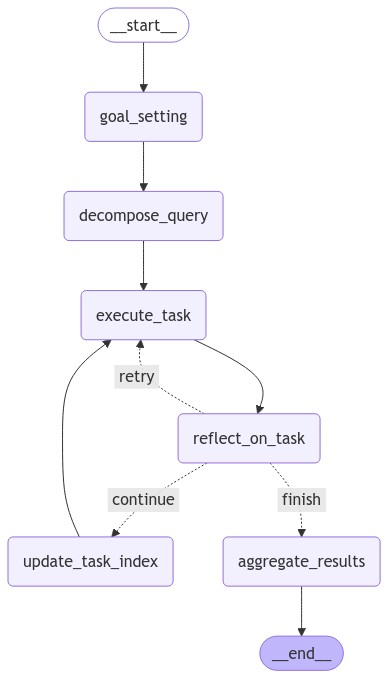

In [10]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
reflection_manager = ReflectionManager(file_path="tmp/self_reflection_db.json")
task_reflector = TaskReflector(llm=llm, reflection_manager=reflection_manager)
agent = ReflectiveAgent(llm=llm, reflection_manager=reflection_manager, task_reflector=task_reflector)
agent.graph_visualization()

In [11]:
def main():
    query = "おいしいカレーライスの作り方"
    llm = ChatOpenAI(
        model=openai_smart_model, temperature=temperature
    )
    reflection_manager = ReflectionManager(file_path="tmp/self_reflection_db.json")
    task_reflector = TaskReflector(llm=llm, reflection_manager=reflection_manager)
    agent = ReflectiveAgent(llm=llm, reflection_manager=reflection_manager, task_reflector=task_reflector)

    result = agent.run(query)

    print(result)

if __name__=="__main__":
    main()

---
**チキンカレーのレシピ**

- **材料:**
  - 鶏肉（もも肉または胸肉）：300〜400g
  - 玉ねぎ：1個
  - トマト：1個
  - にんにく：2片
  - しょうが：1片
  - カレー粉：大さじ2
  - クミンシード：小さじ1
  - コリアンダーパウダー：小さじ1
  - チリパウダー：小さじ1/2
  - ターメリック：小さじ1/2
  - 塩：適量
  - サラダ油：大さじ2
  - 水：200ml
  - ヨーグルト：大さじ2（オプション）

- **手順:**
  1. 鶏肉を一口大に切り、塩とカレー粉少々をまぶしておく。
  2. 玉ねぎ、トマト、にんにく、しょうがをみじん切りにする。
  3. 鍋にサラダ油を熱し、クミンシードを入れて香りが立つまで炒める。
  4. 玉ねぎを加え、透明になるまで炒める。
  5. にんにくとしょうがを加え、さらに炒める。
  6. トマトを加え、柔らかくなるまで炒める。
  7. カレー粉、コリアンダーパウダー、チリパウダー、ターメリックを加え、香りが立つまで炒める。
  8. 鶏肉を加え、全体にスパイスが絡むように炒める。
  9. 水を加え、蓋をして中火で20〜30分煮込む。
  10. ヨーグルトを加え、さらに5分ほど煮込む。
  11. 塩で味を調整する。

- **調理時間:** 約45〜60分

- **コツ:** スパイスは香りを引き出すために、炒める順番が重要です。クミンシードは最初に、他のスパイスは後から加えます。

---

**ビーフカレーのレシピ**

- **材料:**
  - 牛肉（肩ロースやもも肉）：300g
  - 玉ねぎ：1個
  - にんじん：1本
  - じゃがいも：2個
  - 市販のカレールウ：1箱
  - 赤ワイン：100ml（オプション）
  - りんご：1個（すりおろし）
  - 水：500ml

- **手順:**
  1. 野菜を適当な大きさに切る。
  2. 牛肉を炒め、色が変わったら玉ねぎを加えて炒める。
  3. にんじんとじゃがいもを加え、水を入れて煮込む。
  4. りんごをすりおろして加え、カレールウを溶かし入れる。
  5. 赤ワインを加え、さらに煮込んで味を整える。

- **調理時間:** 約1時間

- **コツ

# 6. Cross Reflection
- 実行タスクのリフレクションを他の言語モデルやAIエージェントが実施
- Self reflectionでは同一言語モデルによるReflectionのため、一定のバイアスが加わり、本質的な改善に至らない可能性がある
- AIエージェント自身は性能が低いモデルで実行し、Reflectionを性能の高いモデルで実行することで全体コストを抑えることが可能
- 構成はSelf reflectioとほぼ同じため、main()のみ実装

In [10]:
def main():
    query = "おいしいカレーライスの作り方"

    # AIエージェント用LLM
    agent_llm = ChatOpenAI(
        model="gpt-4o-mini", temperature=temperature
    )

    # Reflection用LLM
    reflector_llm = ChatOpenAI(
        model="gpt-4o", temperature=temperature
    )
    
    reflection_manager = ReflectionManager(file_path="tmp/self_reflection_db.json")
    task_reflector = TaskReflector(llm=reflector_llm, reflection_manager=reflection_manager)
    agent = ReflectiveAgent(llm=agent_llm, reflection_manager=reflection_manager, task_reflector=task_reflector)

    result = agent.run(query)

    print(result)

if __name__=="__main__":
    main()

# ビーフカレーとチキンカレーのレシピ

## ビーフカレーのレシピ

### 必要な材料（4人分）
- 牛肉（もも・角切り）: 300g
- 玉ねぎ: 1個
- にんじん: 1本
- マッシュルーム: 1パック
- りんご: 1/4個
- 赤ワイン: 50ml
- バター（無塩）: 大さじ2
- カレールー: 1箱（中辛）
- 水: 550ml
- 塩: 適量
- 黒こしょう: 適量

### 調理手順
1. **具材の準備**:
   - 牛肉は一口大に切り、玉ねぎ、にんじん、マッシュルームも適当な大きさに切ります。
   - りんごは皮をむいてすりおろします。

2. **牛肉を炒める**:
   - 鍋にバターを溶かし、牛肉を加えて表面が焼き色がつくまで炒めます。

3. **野菜を加える**:
   - 玉ねぎ、にんじん、マッシュルームを加え、玉ねぎが透明になるまで炒めます。

4. **煮込む**:
   - 赤ワインを加え、アルコールを飛ばした後、水を加えます。
   - 沸騰したら、アクを取り除き、蓋をして弱火で約30分煮込みます。

5. **カレールーを加える**:
   - カレールーを加え、よく溶かし、さらに10分煮込みます。

6. **仕上げ**:
   - すりおろしたりんごを加え、塩と黒こしょうで味を調えます。

### 調理時間
- **準備時間**: 約15分
- **調理時間**: 約40分
- **合計時間**: 約55分

### コツやポイント
- **牛肉の選び方**: もも肉や肩ロースを使用すると、柔らかく仕上がります。
- **赤ワインの使用**: 赤ワインを加えることで、深い味わいが出ます。代わりにブイヨンを使うことも可能です。
- **りんごの効果**: りんごを加えることで、自然な甘みが加わり、カレーがまろやかになります。
- **煮込み時間**: 煮込む時間を長くすることで、肉がさらに柔らかくなります。

### 栄養情報（1人前）
- **カロリー**: 約771 kcal
- **タンパク質**: 約22g
- **脂質**: 約24g
- **炭水化物**: 約129g

### 食材の代替案
- **牛肉の代わりに**: 鶏肉や豆腐を使用することができます。
- **赤ワインの代わりに**: ブイヨン